# Clean Retail Dataset Hackathon 1

Import libraries for data analysis and manipulation so that the dataset can be cleaned and prepared for visualisation in PowerBI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Load the retail dataset into a pandas dataframe called retail_raw.
Display the first 5 rows. 

In [2]:
#load dataset into pandas dataframe 
retail_raw = pd.read_csv("../data/retail_raw.csv")
#display first 5 rows
retail_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


## Initial data exploration

Here we made a pandas dataframe called before_summary which summarises the data. 
The new dataframe shows:
- the data types
- the number of null values 
- the number of not null values 
- and how many unique values there are in each column.

The dataframe before_summary will be compared to a dataframe after_summary which will show the same information after the cleaning process. 

In [3]:
# summarise the data with null values and unique values displayed in a dataframe
before_summary = pd.DataFrame({
    "dtype": retail_raw.dtypes,
    "missing_values": retail_raw.isnull().sum(),
    "non_missing": retail_raw.notnull().sum(),
    "unique_values": retail_raw.nunique()
})
before_summary

,dtype,missing_values,non_missing,unique_values
InvoiceNo,object,0,541909,25900
StockCode,object,0,541909,4070
Description,object,1454,540455,4223
Quantity,int64,0,541909,722
InvoiceDate,object,0,541909,23260
UnitPrice,float64,0,541909,1630
CustomerID,int64,0,541909,4372
Country,object,0,541909,38


#### Null Values
There are 1454 null values in the description column meaning that 1454 rows have a missing description. The reason for this is discussed in the cleaning steps below and these will be dealt with later on. 

The command .shape shows us the number of rows and columns in the dataframe. The number of rows is 541909 which is the same as the number of not null values in most of the columns (apart from description which has 1454 null values).

In [4]:
# show shape of pandas dataframe
retail_raw.shape

(541909, 8)

The describe method gives us summary statistics for the numerical columns in the dataframe. We can use this as a quick check for unrealistic values. 

In [5]:
#summary statistics of dataframe
retail_raw.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15287.518434
std,218.081158,96.759853,1484.746041
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14367.000000
50%,3.000000,2.080000,15287.000000
75%,10.000000,4.130000,16255.000000
max,80995.000000,38970.000000,18287.000000


### Data description

We notice that both the unit price and the quantity have values below 0 which we will need to investigate as these are both quantities that should not be below 0. We also notice that the quantity and unit price have high standard deviations with very high maximum values - much higher than the mean value. We will investigate both of these. 

### Change Invoice Date datatype to datetime

The InvoiceDate column contains the dates and times that transactions occured on the website. These are currently datatype object, but we want them to be datatime type which allows PowerBI to treat them as dates and times rather than just strings. This will facilitate our analysis. 

In [6]:
#convert InvoiceData to datetime type
retail_raw['InvoiceDate'] = pd.to_datetime(retail_raw['InvoiceDate'])
retail_raw.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int64
Country                object
dtype: object

### Check distribution of invoices by month and day

We can count the number of invoices by month and plot their distribution

ISSUE: THERE ARE TWO NOVEMBERS (and decembers? - 2010 and 2011) SO NEED TO SPLIT INTO DEC2010 and 2011

In [7]:
month_counts = retail_raw['InvoiceDate'].dt.month_name().value_counts()
month_counts

InvoiceDate
November     84711
December     68006
October      60742
September    50226
July         39518
May          37030
June         36874
March        36748
August       35284
January      35147
April        29916
February     27707
Name: count, dtype: int64

#### Visualise invoice distribution by day

Using value counts we can sum the number of invoices by each day of the week and vidualise them in a bar chart

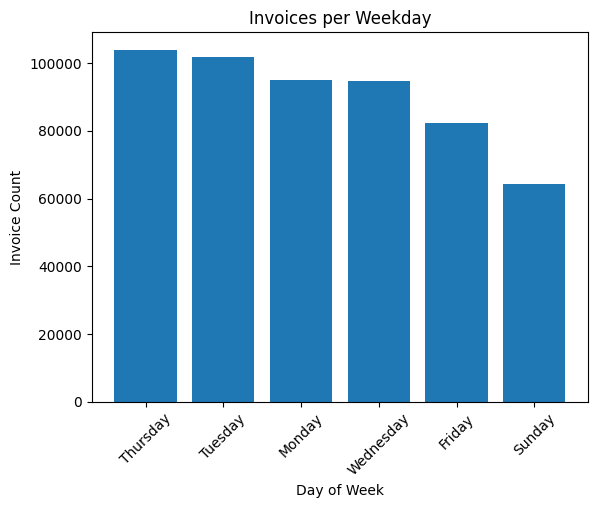

In [8]:
#create a pandas series which sums gives the number of invoices for each day of the week
weekday_counts = retail_raw['InvoiceDate'].dt.day_name().value_counts()

#plot a bar chart using matplotlib to show the distribution of sales across the week
plt.bar(weekday_counts.index, weekday_counts.values)
plt.xlabel('Day of Week')
plt.ylabel('Invoice Count')
plt.title('Invoices per Weekday')
plt.xticks(rotation=45)
plt.show()

As you can see from the bar chart, the busiest day for sales is Thursday with Sunday being the least busy. It is also interesting to note that the dataset does not include sales data for Saturday. 

### Handle Duplicates

Duplicate rows can be identified using the duplicated method, sum gives us the total number of duplicated rows

In [9]:
#sum duplicated rows
retail_raw.duplicated().sum()

np.int64(5268)

5268 duplicates found, we can drop them using drop_duplicates:

In [10]:
#drop duplicates
retail_raw.drop_duplicates(inplace=True)
#number of duplicated rows 
retail_raw.duplicated().sum()

np.int64(0)

### Investigate Negative Quantity and UnitPrice Values

Non positive unit price can be removed and saved as a new dataframe

In [11]:
#keep only the unit price values which are above 0 and save them in a new dataframe called retail
retail = retail_raw[retail_raw['UnitPrice'] > 0]
#quick description to see the new minimum unit price
retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,534129.000000,534129,534129.000000,534129.000000
mean,9.916818,2011-07-04 12:02:01.631403776,4.695864,15282.689715
min,-80995.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 11:36:00,1.250000,14344.000000
50%,3.000000,2011-07-19 15:55:00,2.100000,15287.000000
75%,10.000000,2011-10-18 17:10:00,4.130000,16248.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,216.452113,NaN,95.079189,1486.141831


As you can see from the above describe the minimum unit price is now above 0 which is expected.

Now we can look at the negative values for quantity

In [12]:
#look at the top 10 values for quanntity which are below 0
retail[retail['Quantity'] < 0].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
239,C536391,21484,CHICK GREY HOT WATER BOTTLE,-12,2010-12-01 10:24:00,3.45,17548,United Kingdom
240,C536391,22557,PLASTERS IN TIN VINTAGE PAISLEY,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
241,C536391,22553,PLASTERS IN TIN SKULLS,-24,2010-12-01 10:24:00,1.65,17548,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897,United Kingdom


The invoices in this dataset are generally 6 digit numbers, apart from those which have negative quantity values. These all start with the letter C.
The C stands for cancellation, this [link](https://archive.ics.uci.edu/dataset/352/online+retail) provides some information. 

We have made the assumption that invoices that start with C are canceled orders and so represent orders that were never completed. By this we mean that the sale never occured and that no stock would have been sent to a customer. For this reason we are removing them from the dataset to focus on completed orders. 

In [13]:
#delete all rows with invoices beginning with C
retail = retail[~retail['InvoiceNo'].str.startswith('C', na=False)]

retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,524878.000000,524878,524878.000000,524878.000000
mean,10.616600,2011-07-04 15:30:16.317049088,3.922573,15287.631345
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:13:00,1.250000,14375.000000
50%,4.000000,2011-07-20 11:22:00,2.080000,15287.000000
75%,11.000000,2011-10-19 11:41:00,4.130000,16245.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,156.280031,NaN,36.093028,1482.145530


Minimum quantity is now 1

### Handle Outliers

We will check quantity and unit price for outliers using a box plot and by using the interquartile range (IQR)

Display box plots display the median and IQR using a box with tails, points that are outside the box are then considered to be outliers. 

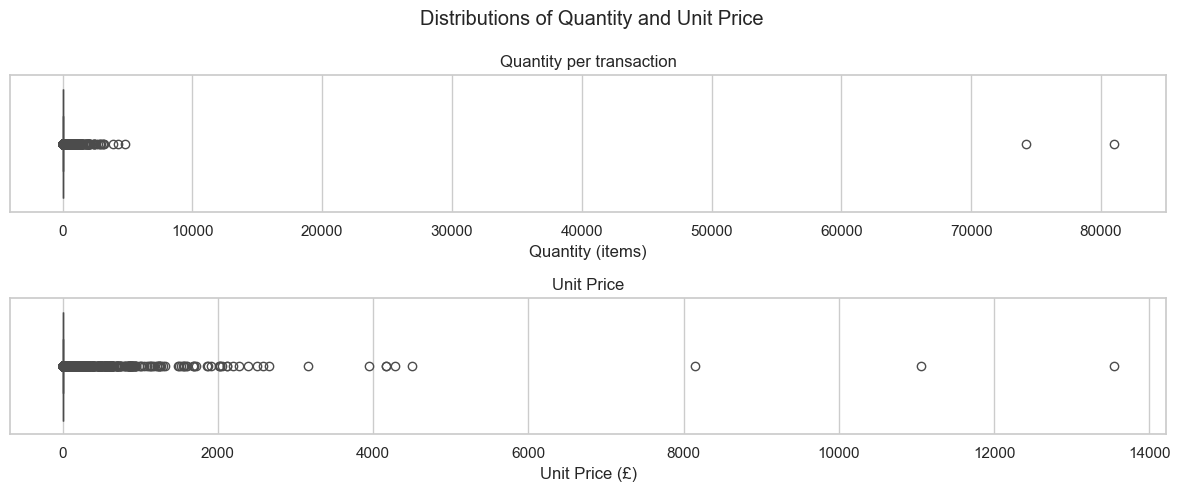

In [ ]:
#set theme
sns.set_theme(style="whitegrid")
#set up two axes
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
#plot quantity on first axis, and unit price on second
sns.boxplot(x=retail['Quantity'], ax=axes[0])
sns.boxplot(x=retail['UnitPrice'], ax=axes[1])
#set title
plt.suptitle("Distributions of Quantity and Unit Price", y=0.98)

#add information to plots
axes[0].set_title("Quantity per transaction")
axes[0].set_xlabel("Quantity (items)")
axes[0].set_yticks([])

axes[1].set_title("Unit Price")
axes[1].set_xlabel("Unit Price (£)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

Both the boxplots for quantity and unit price show outliers that are way above the median, this makes the boxes impossible to see on the scale shown above. 
Below we check for outliers using the IQR

In [ ]:
def check_outlier(s):
    """ Calculating inter quartile range and returning True or False"""
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return (s < low) | (s > high)
#create new columns in the dataframe with booleans to show if a value is an outlier
retail['Quantity_Outlier'] = check_outlier(retail['Quantity'])
retail['UnitPrice_Outlier'] = check_outlier(retail['UnitPrice'])
#sum number of outliers
retail[['Quantity_Outlier', 'UnitPrice_Outlier']].sum()

Quantity_Outlier     27111
UnitPrice_Outlier    37827
dtype: int64

In [ ]:
#show dataframe with new outlier columns 
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Quantity_Outlier,UnitPrice_Outlier
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,False,False
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,False,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,False,False


Remove outliers from retail dataframe

In [31]:
#remove outliers
retail = retail[~retail['Quantity_Outlier']]
retail = retail[~retail['UnitPrice_Outlier']]

New box plot with the outliers removed

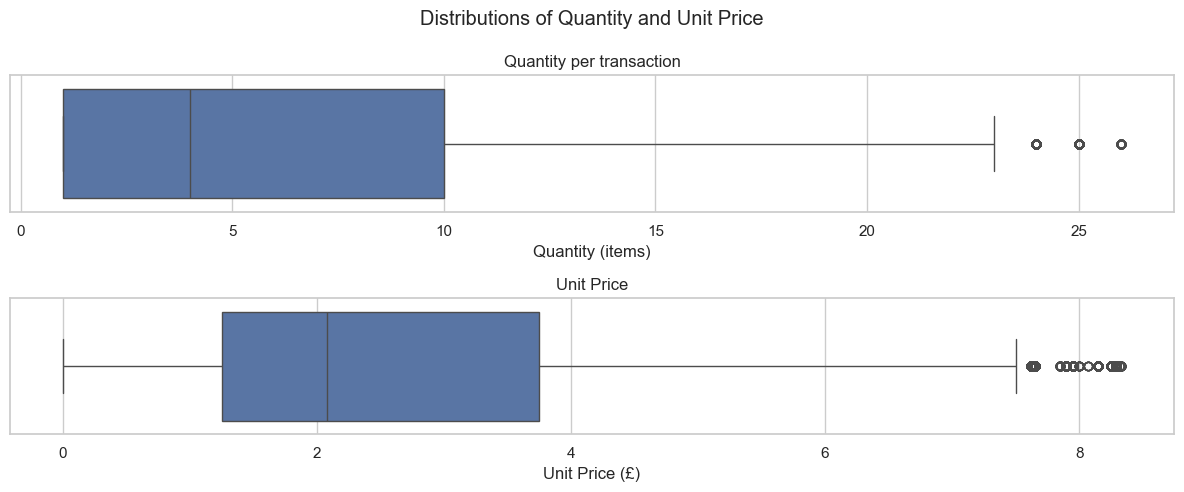

In [32]:
#set theme
sns.set_theme(style="whitegrid")
#set up two axes
fig, axes = plt.subplots(2, 1, figsize=(12, 5))
#plot quantity on first axis, and unit price on second
sns.boxplot(x=retail['Quantity'], ax=axes[0])
sns.boxplot(x=retail['UnitPrice'], ax=axes[1])
#set title
plt.suptitle("Distributions of Quantity and Unit Price", y=0.98)

#add information to plots
axes[0].set_title("Quantity per transaction")
axes[0].set_xlabel("Quantity (items)")
axes[0].set_yticks([])

axes[1].set_title("Unit Price")
axes[1].set_xlabel("Unit Price (£)")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()

Above box plot without outliers shows the distribution more clearly.

Now we can drop the new outlier columns now they are no longer necessary

In [33]:
#drop new outlier columns
retail = retail.drop(columns=['Quantity_Outlier', 'UnitPrice_Outlier'])
retail.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,460251.000000,460251,460251.000000,460251.000000
mean,6.182157,2011-07-05 22:11:46.295260928,2.599133,15309.297257
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000
25%,1.000000,2011-03-29 12:55:00,1.250000,14415.000000
50%,4.000000,2011-07-21 12:15:00,2.080000,15287.000000
75%,10.000000,2011-10-20 09:57:00,3.750000,16303.000000
max,26.000000,2011-12-09 12:50:00,8.330000,18287.000000
std,6.396944,NaN,1.929225,1479.257330


### Add new date and time columns

The invoice column had both the date and time that transactions occured. We decided to split these into a column for just the date and a separate one for the time. This will allow for more simple analysis in PowerBI, and it will allow us to sort transactions into time bins to allow us to investigate customer behaviour.

In [34]:
#add new time column
retail['InvoiceDate_time'] = retail['InvoiceDate'].dt.time
#add new data column
retail['InvoiceDate_date'] = retail['InvoiceDate'].dt.date
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_time,InvoiceDate_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,08:26:00,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,08:26:00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01


To analyse customer behaviour we decided to make "day part bins" and sort the transactions into which part of the day they fall into. The day parts are as follows, depending on the time of the interaction.
- Night
- Morning
- Lunch
- Afternoon
- Evening
- Late
The invoices in the dataframe will then be categorised by which part of the day the transaction occured.

In [36]:
bins = [0, 6, 11, 14, 17, 21, 24]
#day part categories
labels = ['Night', 'Morning', 'Lunch', 'Afternoon', 'Evening', 'Late']
#update dataframe
retail['daypart'] = pd.cut(retail['InvoiceDate'].dt.hour, bins=bins, labels=labels, right=False)

Below is the updated dataframe with the new day part column. 

In [37]:
#show first 5 rows of the dataframe
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_time,InvoiceDate_date,daypart
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,08:26:00,2010-12-01,Morning
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,08:26:00,2010-12-01,Morning
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning


### Total transaction value

We added a new column into the datafrane which is the total transaction value. This is the unit price (or the price per item) multiplied by the quantity (the number of items). This will give us how much was spent in each interaction. 

In [38]:
#new column TotalTransactionValue is quantity * unitprice
retail['TotalTransacrtionValue'] = retail['Quantity'] * retail['UnitPrice']
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_time,InvoiceDate_date,daypart,TotalTransacrtionValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,08:26:00,2010-12-01,Morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,08:26:00,2010-12-01,Morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,12:50:00,2011-12-09,Lunch,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12:50:00,2011-12-09,Lunch,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,12:50:00,2011-12-09,Lunch,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,12:50:00,2011-12-09,Lunch,16.60


### Product code case

The product code has a mixture of uppercase on some products and lowercase on others, so we standadised the case on the whole column.

In [ ]:
#make the case uppercase on stockcode
retail['StockCode'] = retail['StockCode'].str.upper().str.strip()
retail

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_time,InvoiceDate_date,daypart,TotalTransacrtionValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,08:26:00,2010-12-01,Morning,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,08:26:00,2010-12-01,Morning,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,12:50:00,2011-12-09,Lunch,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12:50:00,2011-12-09,Lunch,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,12:50:00,2011-12-09,Lunch,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,12:50:00,2011-12-09,Lunch,16.60


### Anonymise customer ID

So that customers could not be identified we made them anonymous by changing them to customer-1, customer-2 etc

In [ ]:
#get unique customer ids
unique_customers = retail['CustomerID'].unique()
#map new ids to replace the old ones
customer_map = {num: f'Customer-{i+1}' for i, num in enumerate(unique_customers)}
#make a new column with the anonymous ids
retail['anon_customer'] = retail['CustomerID'].map(customer_map)

retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDate_time,InvoiceDate_date,daypart,TotalTransacrtionValue,anon_customer
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,08:26:00,2010-12-01,Morning,15.30,Customer-1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,08:26:00,2010-12-01,Morning,22.00,Customer-1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1


drop cusotmer id

In [99]:
retail = retail.drop(columns=['CustomerID'])
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,InvoiceDate_time,InvoiceDate_date,daypart,TotalTransacrtionValue,anon_customer
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom,08:26:00,2010-12-01,Morning,15.30,Customer-1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom,08:26:00,2010-12-01,Morning,22.00,Customer-1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom,08:26:00,2010-12-01,Morning,20.34,Customer-1


Create after summary:

In [100]:
after_summary = pd.DataFrame({
    "dtype": retail.dtypes,
    "missing_values": retail.isnull().sum(),
    "non_missing": retail.notnull().sum(),
    "unique_values": retail.nunique()
})

View before summary again:

In [101]:
before_summary

,dtype,missing_values,non_missing,unique_values
InvoiceNo,object,0,541909,25900
StockCode,object,0,541909,4070
Description,object,1454,540455,4223
Quantity,int64,0,541909,722
InvoiceDate,object,0,541909,23260
UnitPrice,float64,0,541909,1630
CustomerID,int64,0,541909,4372
Country,object,0,541909,38


view after summary:

In [102]:
after_summary

,dtype,missing_values,non_missing,unique_values
InvoiceNo,object,0,460251,18276
StockCode,object,0,460251,3609
Description,object,0,460251,3800
Quantity,int64,0,460251,26
InvoiceDate,datetime64[ns],0,460251,17027
UnitPrice,float64,0,460251,285
Country,object,0,460251,38
InvoiceDate_time,object,0,460251,734
InvoiceDate_date,object,0,460251,305
daypart,category,0,460251,4


Save cleaned csv file

In [103]:
retail.to_csv("../data/retail_clean.csv", index=False)

Create sales fact table

In [104]:
sales_fact = retail.copy()[['InvoiceNo', 'StockCode', 'Quantity', 'UnitPrice', 'TotalTransacrtionValue', 'anon_customer', 'InvoiceDate_time', 'InvoiceDate_date', 'daypart']]
sales_fact.to_csv("../data/FactSales.csv", index=False)

Create product dimension table

In [105]:
dim_product = (
    retail.groupby('StockCode')['Description']
    .agg(lambda x: x.value_counts().index[0])  # most frequent description
    .reset_index()
    .sort_values('StockCode')
)

dim_product.to_csv("../data/DimProduct.csv", index=False)

Create customer dimention table and add continent

In [106]:
continent_map = {
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Norway': 'Europe',
    'Switzerland': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Italy': 'Europe',
    'Belgium': 'Europe',
    'Lithuania': 'Europe',
    'Iceland': 'Europe',
    'Denmark': 'Europe',
    'Cyprus': 'Europe',
    'Spain': 'Europe',
    'Finland': 'Europe',
    'Austria': 'Europe',
    'Sweden': 'Europe',
    'Netherlands': 'Europe',
    'Greece': 'Europe',
    'Channel Islands': 'Europe',
    'EIRE': 'Europe',  # Ireland
    'European Community': 'Europe',
    'Malta': 'Europe',
    'Czech Republic': 'Europe',
    'USA': 'North America',
    'Canada': 'North America',
    'Brazil': 'South America',
    'Israel': 'Middle East',
    'Lebanon': 'Middle East',
    'Saudi Arabia': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Bahrain': 'Middle East',
    'Japan': 'Asia',
    'Hong Kong': 'Asia',
    'Singapore': 'Asia',
    'Australia': 'Oceania',
    'RSA': 'Africa',
    'Unspecified': 'Unknown'
}


dim_customer = (
    retail.groupby('anon_customer')
    .agg(
          FirstPurchaseDate=('InvoiceDate', 'min'),
          Country=('Country', 'first')
      )
      .reset_index()   
)

dim_customer['FirstPurchaseYear'] = dim_customer['FirstPurchaseDate'].dt.year
dim_customer['FirstPurchaseMonth'] = dim_customer['FirstPurchaseDate'].dt.month
dim_customer['FirstPurchaseYearMonth'] = dim_customer['FirstPurchaseDate'].dt.strftime('%Y-%m')
dim_customer['Continent'] = dim_customer['Country'].map(continent_map).fillna('Other')
dim_customer.to_csv("../data/DimCustomer.csv", index=False)

Create date dimention table

In [107]:
date_range = pd.date_range(retail['InvoiceDate'].min(), retail['InvoiceDate'].max())

dim_date = pd.DataFrame({'Date': date_range})
dim_date['Year'] = dim_date['Date'].dt.year
dim_date['Quarter'] = dim_date['Date'].dt.to_period('Q').astype(str)
dim_date['MonthNumber'] = dim_date['Date'].dt.month
dim_date['MonthName'] = dim_date['Date'].dt.strftime('%B')
dim_date['DayOfMonth'] = dim_date['Date'].dt.day
dim_date['DayOfWeekNumber'] = dim_date['Date'].dt.weekday + 1
dim_date['DayOfWeekName'] = dim_date['Date'].dt.strftime('%A')
dim_date['IsWeekend'] = dim_date['DayOfWeekNumber'] >= 6
dim_date['YearMonth'] = dim_date['Date'].dt.strftime('%Y-%m')
dim_date['Date'] = dim_date['Date'].dt.date

dim_date.to_csv("../data/DimDate.csv", index=False)

Create day part dimention

In [108]:
bins = [0, 6, 11, 14, 17, 21, 24]
labels = ['Night', 'Morning', 'Lunch', 'Afternoon', 'Evening', 'Late']

dim_daypart = pd.DataFrame({
    'daypart': labels,
    'StartHour': bins[:-1],
    'EndHour': bins[1:]
})

dim_daypart['HoursInBin'] = dim_daypart['EndHour'] - dim_daypart['StartHour']
dim_daypart.to_csv("../data/DimDayPart.csv", index=False)